<div class="notebook-quickstart">
<h3>Quickstart</h3>
To run the code below:
<ol>
<li>Click on the cell to select it.</li>
<li>Press <code>SHIFT+ENTER</code> on your keyboard or press the play button
   (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above</li>
</ol>
Feel free to create new cells using the plus button
(<button class='fa fa-plus icon-plus btn btn-xs btn-default'></button>), or pressing <code>SHIFT+ENTER</code> while this cell
is selected.
</div>

In this article we demonstrate how Brian can be used to simulate non-neural aspects of the model. This is an idealized model of the smooth pursuit reflex, including two ocular muscles, a moving visual stimulus and spiking neural control.

This article is adapted from our eLife paper [(Stimberg et al. 2019)](https://elifesciences.org/articles/47314), which includes an interactive version that you can play with [here](https://github.com/brian-team/brian2_paper_examples).

In [32]:
from brian2 import *
%matplotlib notebook
seed(79620)

Each of the two antagonistic ocular muscles is modelled as a spring of elasticity $k$ and some friction. To simplify, we consider that the eye moves laterally, rather than rotate. If $x$ is the position of the eye with 0 being the center, then the lengths of the springs are $L+x$ and $L-x$. The dynamics of the eye is then given by a second-order differential equation:
$$ m\frac{d^2x}{dt^2} = - k\left(\left(L+x\right)-x_L\right) + k\left(\left(L-x\right)-x_R\right) - f\frac{dx}{dt}$$
or:
$$ m\frac{d^2x}{dt^2} = k(x_L-x_R-2x) - f\frac{dx}{dt}$$

We see that $x_0 = \frac{1}{2}(x_L-x_R)$ is the equilibrium position of the eye. Here we have assumed that spring elasticities are identical. We can rewrite this equation with just two parameters $\alpha$ and $\beta$:
$$ \frac{d^2x}{dt^2} = \alpha(x_0 - x) - \beta\frac{dx}{dt}$$

We will assume that eye position can move between -1 and 1.

We consider that the resting length is the variable on which motoneurons act. Each spike from a motoneuron produces a waveform of contraction ("twitch"), i.e., a change in resting length. We consider that contractions add linearly, and resting lengths relax exponentially. By linearity it follows that we can simply express the action of motoneurons on the equilibrium position of the eye $x_0$, which relaxes exponentially to the center position 0.

Finally, we consider a visual object that performs a random walk according to an Ornstein–Uhlenbeck with 0 as the central location.

In [2]:
alpha = (1/(50*ms))**2 # characteristic relaxation time is 50 ms
beta = 1/(50*ms) # friction parameter
tau_muscle = 20*ms # relaxation time of muscle contraction
tau_object = 500*ms # time constant of object movement

eqs_eye = '''
dx/dt = velocity : 1
dvelocity/dt = alpha*(x0-x)-beta*velocity : 1/second
dx0/dt = -x0/tau_muscle : 1
dx_object/dt = (noise - x_object)/tau_object:  1
dnoise/dt = -noise/tau_object + tau_object**-0.5*xi : 1
'''
eye = NeuronGroup(1, model=eqs_eye, method='euler')

We now define two motoneurons, one for each muscle:

In [3]:
taum = 20*ms
motoneurons = NeuronGroup(2, model= 'dv/dt = -v/taum : 1', threshold = 'v>1',
                          reset = 'v=0', refractory = 5*ms, method='exact')

The motoneurons project to the eye, and each spike produces a small contraction.

In [4]:
motosynapses = Synapses(motoneurons, eye, model = 'w : 1', on_pre = 'x0+=w')
motosynapses.connect() # connects all motoneurons to the eye
motosynapses.w = [-0.5,0.5]

We now implement the sensory neurons, which we simplify by considering spiking neurons which directly respond to light, i.e they represent both photoreceptors and retinal ganglion cells. We model this by giving each neuron a 1d position $x_{neuron}$, the eye a position $x_{eye}$ and object position $x_{object}$ and setting the input current to each neuron as proportional to $\exp(-((x_{object}-x_{eye}-x_{neuron})/w)^2)$, where $w$ is a receptive field width parameter.

In [5]:
N = 20
width = 2./N # width of receptive field
gain = 4.
eqs_retina = '''
I = gain*exp(-((x_object-x_eye-x_neuron)/width)**2) : 1
x_neuron : 1 (constant)
x_object : 1 (linked) # position of the object
x_eye : 1 (linked) # position of the eye
dv/dt = (I-(1+gs)*v)/taum : 1
gs : 1 # total synaptic conductance
'''
retina = NeuronGroup(N, model = eqs_retina, threshold = 'v>1', reset = 'v=0', method='exact')
retina.v = 'rand()'
retina.x_eye = linked_var(eye, 'x')
retina.x_object = linked_var(eye, 'x_object')
retina.x_neuron = '-1.0 + 2.0*i/(N-1)'

Finally we connect sensory neurons to motoneurons. Sensory neurons on each hemifield connects to the corresponding motoneuron, with a strength that scales with eccentricity:

In [6]:
sensorimotor_synapses = Synapses(retina, motoneurons, model = 'w : 1 (constant)', on_pre = 'v+=w')
sensorimotor_synapses.connect(j = 'int(x_neuron_pre > 0)')
sensorimotor_synapses.w = '20*abs(x_neuron_pre)/N_pre'

We record the position of the eye, of the object, and spikes produced by the retina and motoneurons:

In [7]:
M = StateMonitor(eye, ('x', 'x0', 'x_object'), record = True)
S_retina = SpikeMonitor(retina)
S_motoneurons = SpikeMonitor(motoneurons)

We now can run the simulation:

In [ ]:
run(10*second)

Finally, we plot the results

<IPython.core.display.Javascript object>


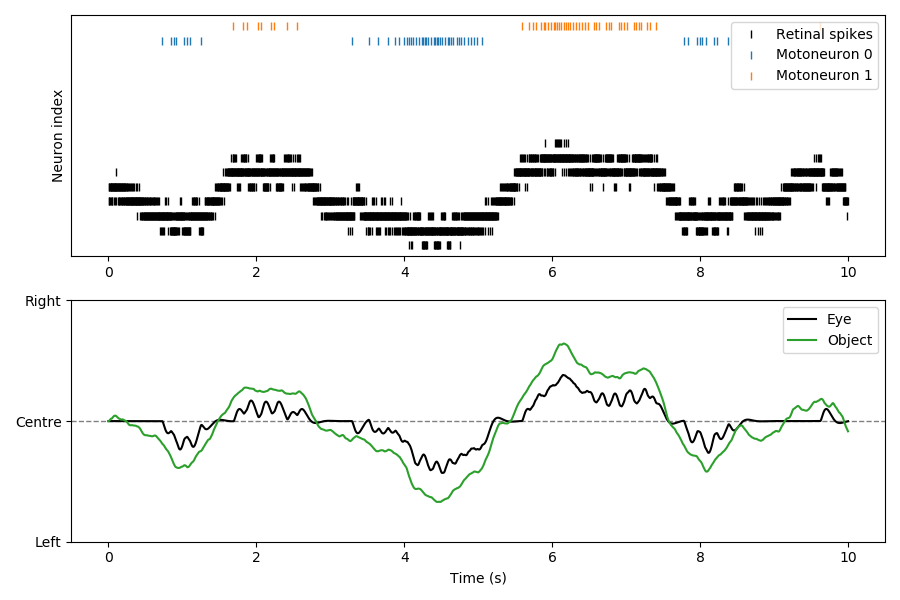

In [37]:
figure(figsize=(9, 6))
ax = subplot(211)
plot(S_retina.t/second, S_retina.i[:], '|k', label='Retinal spikes')
plot(motoneuron_spikes[0]/second, np.ones(S_motoneurons.count[0])*N, '|C0', label='Motoneuron 0')
plot(motoneuron_spikes[1]/second, np.ones(S_motoneurons.count[1])*(N+1), '|C1', label='Motoneuron 1')
legend(loc='upper right')
ylabel('Neuron index')
yticks([])
subplot(212, sharex=ax)
axhline(0, c='gray', lw=1, ls='--')
plot(M.t/second, M.x[0], '-k', label='Eye')
plot(M.t/second, M.x_object[0], '-C2', label='Object')
xlabel('Time (s)')
yticks([-1, 0, 1], ['Left', 'Centre', 'Right'])
legend(loc='upper right')
tight_layout()